In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage
from skimage.filters import gaussian
from skimage.transform import resize
from skimage import color
import cv2

In [6]:
#This cell contains all the functions used in Phase I
#FIRST FUNCTION

def loadImages(img):

    double_img = np.asarray(img, dtype=np.float64)
    gray_img = color.rgb2gray(double_img)
    return gray_img




In [7]:
#SECOND FUNCTION

def getFeaturePoints(gray_input_img):



    #Define RGB2gray function
    def rgb2gray(img) :
        return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

    #Detemine gradient function for Fx and Fy using sobel filter(normlized)
    def gradient_x(img) :
        grad_img = ndimage.convolve(img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
        return grad_img/np.max(grad_img)

    def gradient_y(img) :
        grad_img = ndimage.convolve(img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))
        return grad_img/np.max(grad_img)

    #Apply gaussian blurring
    blur_img = ndimage.gaussian_filter(gray_input_img, sigma = 1.0)

    #Find gradient Fx and Fy
    x_grad = gradient_x(blur_img)
    y_grad = gradient_y(blur_img)

    #Find corners
    xx_grad = x_grad * x_grad
    yy_grad = y_grad * y_grad
    xy_grad = x_grad * y_grad
    tuple_data = [] #Contains y, x Co-ordinates and its corner response
    k = 0.04
    max = 0


    for i in range(1, int(gray_input_img.shape[0] - 1)) :
            for j in range(1, int(gray_input_img.shape[1] - 1)) :
                window_x = xx_grad[i-4 : i+5 , j-4 : j+5]
                window_y = yy_grad[i-4 : i+5 , j-4 : j+5]
                window_xy = xy_grad[i-4 : i+5 , j-4 : j+5]
                sum_xx = np.sum(window_x)
                sum_yy = np.sum(window_y)
                sum_xy = np.sum(window_xy)
                determinant = (sum_xx * sum_yy) - (sum_xy * sum_xy)
                trace = sum_xx + sum_yy
                R = determinant - (k * trace * trace)
                tuple_data.append((i, j, R))
                if(R > max) :
                    max = R
    print(max)
    #L contains y, x co-ordinate(whose value is greater than threshold) and their corner response of those co-ordinates
    ratio = [0.05]
    count = 0 #for equivalent ratio access
    L = []
    thres_ratio = ratio[count]
    count+=1
    threshold = thres_ratio * max
    for res in tuple_data :
        i, j, R = res
        if R > threshold :
            L.append([i, j, R])

    #Phase III : Non maximal suppression
    sorted_L = sorted(L, key = lambda x: x[2], reverse = True)
    final_L = [] #final_l contains list after non maximal suppression
    final_L.append(sorted_L[0][:-1])
    dis = 10
    xc, yc = [], []
    for i in sorted_L :
        for j in final_L :
            if(abs(i[0] - j[0] <= dis) and abs(i[1] - j[1]) <= dis) :
                break
        else :
            final_L.append(i[:-1])
            xc.append(i[1])
            yc.append(i[0])
    print(len(sorted_L))
    print(len(final_L))

    #Print Final Image
    corner_img = np.zeros(gray_input_img.shape)
    #(input_img.shape[0], input_img.shape[1], 3), dtype = np.uint8)

    for i in final_L :
        y, x = i[0], i[1]
        corner_img[y][x] = 1

    return xc, yc


230.42681217955038
30398
209


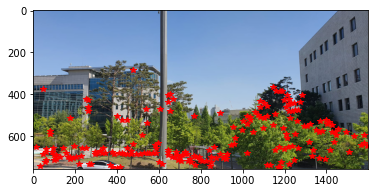

In [16]:
# Harris Corner Detector Implementation and test

input_img2 = imageio.imread("photos/img8.jpeg")

gray_input_img2 = loadImages(input_img2)

# Plot feature points
y_pixels2, x_pixels2 = getFeaturePoints(gray_input_img2)

plt.imshow(input_img2, cmap = plt.get_cmap('gray'))
plt.plot(y_pixels2, x_pixels2, '*', color='red')
plt.show()


In [17]:
#THIRD FUNCTION

def getFeatureDescriptors(image, x_values, y_values, window_size):
    # image_descriptors = np.array([])

    descriptors = None
    for i in range(len(x_values)):
        if x_values[i] > 700:
            continue
        elif y_values[i] > 1500:
            continue
        elif x_values[i] < 50:
            continue
        elif y_values[i] < 50:
            continue
        else:
            n_x = (window_size*2)+1
            new_window = np.zeros((n_x, n_x))
            p = 0
            t = 0

            for row in range(x_values[i] - window_size, x_values[i] + window_size + 1):
                for col in range(y_values[i] - window_size, y_values[i] + window_size + 1):
                        new_window[p][t] = image[row][col]
                        t=t+1
                p=p+1
                t=0
                g_result = gaussian(new_window)
                resized_window = resize(g_result, (3,3))
                mean_window = np.mean(resized_window)
                sdt_dvtn_window = np.std(resized_window)

                subtracted_mean =  mean_window - resized_window
            temp = np.reshape(subtracted_mean / sdt_dvtn_window, (1,9))
            if descriptors is not None:
                descriptors = np.vstack((descriptors, temp))
            else:
                descriptors = temp

    return descriptors


In [18]:
image8_descriptors = getFeatureDescriptors(gray_input_img2, x_pixels2, y_pixels2, 19)


(158, 9)


In [ ]:
# We didn't make it.
def match2Images():

    return matches

In [80]:
def refineMatches(match_list, threshold, rounds):

    final_homography, final_count, final_residual, rate, final_flag = None, None, None, None, None

    # Rounds to run RANSAC
    for iteration in range(rounds):

        # Get homography matrix
        matrix = np.zeros((8, 9))
        for i in range(4):
            x1, y1, x2, y2 = match_list[int(np.random.rand() * match_list.shape[0])]
            matrix[i * 2] = np.array([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
            matrix[i * 2 + 1] = np.array([0, 0, 0, x1, y1, 1, -x2*x1, -x2*y1, -y2])
        matrix = np.matmul(matrix.transpose(), matrix)
        eig_value, eig_vector = np.linalg.eig(matrix)
        homography = eig_vector[np.argmin(eig_value)].reshape([3,3])

        # Calculate inlier survival rate
        count, residual = 0, 0
        flag = np.zeros((match_list.shape[0], 1))
        for i in range(match_list.shape[0]):
            before, after = np.hstack((match_list[i][:2], 1)), np.hstack((match_list[i][2:], 1))
            after1 = np.matmul(homography, before.transpose()).transpose()
            l2 = np.linalg.norm(after - after1)
            if l2 < threshold:
                count += 1
                residual += l2 ** 2
                flag[i] = 1
        if rate is None or count / match_list.shape[0] > rate:
            rate = count / match_list.shape[0]
            final_homography, final_count, final_residual, final_flag = homography, count, residual, flag

    print('Number of inliers: ', final_count, ' Average residual: ', final_residual / count)
    print('Surviving matches: ', (match_list[i] for i in range(match_list.shape[0]) if final_flag[i] == 1))

    return final_homography

[0 1 1]
(20, 4, 1)


In [ ]:
import cv2

# Dimension of homography is 9 x 3 x 3, image is 10 x X x Y
def warpImages(homography, image):

    l = []
    mtx = None
    for i in range(image.shape[0]):

        if mtx is None:
            mtx = homography[0]
        else:
            mtx = np.matmul(mtx, homography[i])

        out = cv2.warpPerspective(image[i+1], matrix, (image.shape[2], image.shape[1]))
        l.append(out)
    return l

(757, 1600, 3)
